In [1]:
import tensorflow as tf
import numpy as np
import glob
import xarray as xr
from tensorflow.keras import layers, models, optimizers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats

%reload_ext autoreload
%autoreload 2

# Configure environment
tf.get_logger().setLevel('ERROR')
TF_ENABLE_ONEDNN_OPTS = 0

2025-04-07 16:43:09.034363: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# Function to compute weighted spatial averages
def weighted_spatial(data_array, lats):
    weights = np.cos(np.deg2rad(lats))
    weighted_data_array = np.multiply(data_array, weights[:, np.newaxis])
    weighted_sum = np.nansum(weighted_data_array.reshape(-1), axis=0)
    denom = np.nansum(weights) * 144
    return np.divide(weighted_sum, denom)


# Function to load data
def get_data(paths):
    X_MAPS = []
    Y_DATA = []
    model_names = []
    for path in paths:
        model_names.append(path.split('/')[8][:-3])

        # Load data
        ds = xr.open_dataset(path)
        ds_sel = ds.sel(period=slice(1900, 2050))

        # Get SAT & SLP or SLP data
        if SAT_SLP:
            X_maps_sat = ds_sel.X_SAT_SLP[:, :, :, :, :, 0]
            X_maps_slp = ds_sel.X_SAT_SLP[:, :, :, :, :, 1]
            X_maps = [X_maps_sat, X_maps_slp]
            X_maps = np.moveaxis(X_maps, 0, -1)
        else:
            X_maps = np.array(ds_sel.X_SAT_SLP[:, :, :, :, :, 0])

        Y_data = np.array(ds_sel.Y_I_E_SUM)

        # Append to all paths
        X_MAPS.append(X_maps)
        Y_DATA.append(Y_data)

        ds.close()
    return X_MAPS, Y_DATA, model_names


# Observations actual trend computation
def compute_actual_trends(obs_maps):
    all_obs = obs_maps[0:3], obs_maps[3:6], obs_maps[6:9], obs_maps[9:12]
    lats = np.arange(-88.75, 88.751, 2.5)[64:] if region == 'Arctic' else np.arange(-88.75, 88.751, 2.5)

    if SAT_SLP:
        actual_trends_all_obs = []
        for SAT in range(4):
            actual_trends_one_obs = []
            for SLP in range(3):
                actual_trends = []
                for season in range(4):
                    obs_grid = all_obs[SAT][SLP, season, 20:, :, 0]  if region == 'Arctic' else all_obs[SAT][SLP, season, :, :, 0]
                    actual_trends.append(weighted_spatial(obs_grid, lats))
                actual_trends_one_obs.append(actual_trends)
            actual_trends_all_obs.append(actual_trends_one_obs)
        actual_trends_obs_means = np.nanmean(actual_trends_all_obs, axis=1)

    else:
        actual_trends_obs_means = []
        for SAT in range(4):
            actual_trends_one_obs = []
            for season in range(4):
                obs_grid = obs_maps[SAT, season, 20:] if region == 'Arctic' else obs_maps[SAT, season]
                actual_trends_one_obs.append(weighted_spatial(obs_grid, lats))
            actual_trends_obs_means.append(actual_trends_one_obs)
        actual_trends_obs_means = np.array(actual_trends_obs_means)

    # Swap spring and summer since they are out of order for some reason
    actual_trends_obs_means[:, [2, 1]] = actual_trends_obs_means[:, [1, 2]]
    obs_maps[:, [2, 1]] = obs_maps[:, [1, 2]]

    return actual_trends_obs_means, obs_maps


def create_CNN(input_shape):
    inpt = layers.Input(shape=input_shape)

    # Convolutional layer
    conv = layers.Conv2D(16, (3, 7), padding='same', activation='relu')(inpt)
    pool = layers.MaxPooling2D(1)(conv)
    drop = layers.Dropout(0.5)(pool)

    # Flatten and output layer
    flat = layers.Flatten()(drop)
    out = layers.Dense(2)(flat)

    model = models.Model(inputs=inpt, outputs=out)
    model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate=1e-4))
    return model


def prepare_data(splice_X, splice_Y, hist_X, hist_Y, cv):
    # Bootstrap 10 ensemble members to train on from models with more than 10 members
    splice_X_10ens = []
    splice_Y_10ens = []
    for idx in range(len(splice_X)):
        random_idxs = tf.random.shuffle(tf.range(tf.shape(splice_X[idx])[0]))[:10]
        splice_X_10ens.append(tf.gather(splice_X[idx], random_idxs))
        splice_Y_10ens.append(tf.gather(splice_Y[idx], random_idxs))
    hist_X_10ens = []
    hist_Y_10ens = []
    for idx in range(len(hist_X)):
        random_idxs = tf.random.shuffle(tf.range(tf.shape(hist_X[idx])[0]))[:10]
        hist_X_10ens.append(tf.gather(hist_X[idx], random_idxs))
        hist_Y_10ens.append(tf.gather(hist_Y[idx], random_idxs))

    # Delete the specified index and concatenate, specify for E3SM-2-0
    if no_E3SM:
        if cv == 0:
            # print('  E3SMv2 exception: All other data used for training.')
            X_train_spliced = tf.concat([splice_X_10ens[i] for i in range(tf.shape(splice_X_10ens)[0])], axis=0)
            Y_train_spliced = tf.concat([splice_Y_10ens[i] for i in range(tf.shape(splice_Y_10ens)[0])], axis=0)
        else:
            X_train_spliced = tf.concat([splice_X_10ens[i] for i in range(tf.shape(splice_X_10ens)[0]) if i != cv], axis=0)
            Y_train_spliced = tf.concat([splice_Y_10ens[i] for i in range(tf.shape(splice_Y_10ens)[0]) if i != cv], axis=0)
    else:
        X_train_spliced = tf.concat([splice_X_10ens[i] for i in range(tf.shape(splice_X_10ens)[0]) if i != cv], axis=0)
        Y_train_spliced = tf.concat([splice_Y_10ens[i] for i in range(tf.shape(splice_Y_10ens)[0]) if i != cv], axis=0)

    # Concatenate the hist tensors
    X_train_hist = tf.concat(hist_X_10ens, axis=0)
    Y_train_hist = tf.concat(hist_Y_10ens, axis=0)

    # Reshape to put ensembles and time periods in same axis
    if region == 'Arctic':
        if SAT_SLP:
            X_train_spliced = tf.reshape(X_train_spliced, (-1, X_train_spliced.shape[2], X_train_spliced.shape[3], X_train_spliced.shape[4]))
            X_train_hist = tf.reshape(X_train_hist, (-1, X_train_hist.shape[2], X_train_hist.shape[3], X_train_hist.shape[4]))
        else:
            X_train_spliced = tf.reshape(X_train_spliced, (-1, X_train_spliced.shape[2], X_train_spliced.shape[3]))
            X_train_hist = tf.reshape(X_train_hist, (-1, X_train_hist.shape[2], X_train_hist.shape[3]))
        Y_train_spliced = tf.reshape(Y_train_spliced, (-1, Y_train_spliced.shape[2]))
        Y_train_hist = tf.reshape(Y_train_hist, (-1, Y_train_hist.shape[2]))
    else:
        if SAT_SLP:
            X_train_spliced = tf.reshape(X_train_spliced, (-1, X_train_spliced.shape[3], X_train_spliced.shape[4], X_train_spliced.shape[5]))
            X_train_hist = tf.reshape(X_train_hist, (-1, X_train_hist.shape[3], X_train_hist.shape[4], X_train_hist.shape[5]))
        else:
            X_train_spliced = tf.reshape(X_train_spliced, (-1, X_train_spliced.shape[3], X_train_spliced.shape[4]))
            X_train_hist = tf.reshape(X_train_hist, (-1, X_train_hist.shape[3], X_train_hist.shape[4]))
        Y_train_spliced = tf.reshape(Y_train_spliced, (-1, Y_train_spliced.shape[3]))
        Y_train_hist = tf.reshape(Y_train_hist, (-1, Y_train_hist.shape[3]))

    # Concatenate and reshape training data
    X_train = tf.concat([X_train_spliced, X_train_hist], axis=0)
    Y_train = tf.concat([Y_train_spliced, Y_train_hist], axis=0)
    return X_train, Y_train

In [3]:
# Main
region = 'Global'
no_E3SM = True
s = 1  # spring
SAT_SLP = True if region == 'Arctic' else False

In [4]:
# Load observation data
obs_maps = []
if SAT_SLP:
    for sat_path in np.sort(glob.glob('/glade/work/skygale/training-data/seasonal/observations/sat/*'))[::-1]:
        ds_sat = xr.load_dataset(sat_path)
        X_maps_sat = ds_sat.DATA[:, 44:] if region == 'Arctic' else ds_sat.DATA
        for slp_path in glob.glob('/glade/work/skygale/training-data/seasonal/observations/slp/*'):
            ds_slp = xr.load_dataset(slp_path)
            X_maps_slp = ds_slp.DATA[:, 44:] if region == 'Arctic' else ds_slp.DATA
            obs_maps.append(np.stack([X_maps_sat, X_maps_slp], axis=-1))
else:
    for sat_path in np.sort(glob.glob('/glade/work/skygale/training-data/seasonal/observations/sat/*'))[::-1]:
        print(sat_path)
        ds_sat = xr.load_dataset(sat_path)
        obs_maps.append(ds_sat.DATA[:, 44:] if region == 'Arctic' else ds_sat.DATA)

obs_maps = np.array(obs_maps)
actual_trends_obs_means, obs_maps = compute_actual_trends(obs_maps)

/glade/work/skygale/training-data/seasonal/observations/sat/NOAAv6.nc
/glade/work/skygale/training-data/seasonal/observations/sat/HadCRUTv5.nc
/glade/work/skygale/training-data/seasonal/observations/sat/GISTv4.nc
/glade/work/skygale/training-data/seasonal/observations/sat/BerkeleyEarth.nc


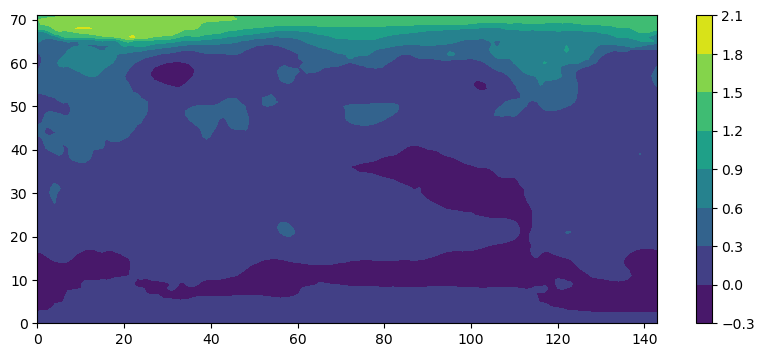

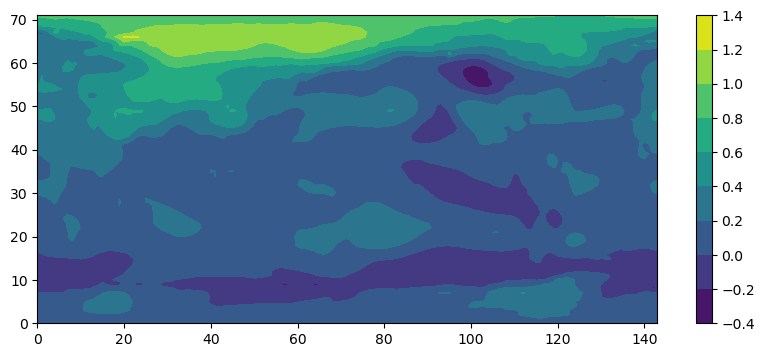

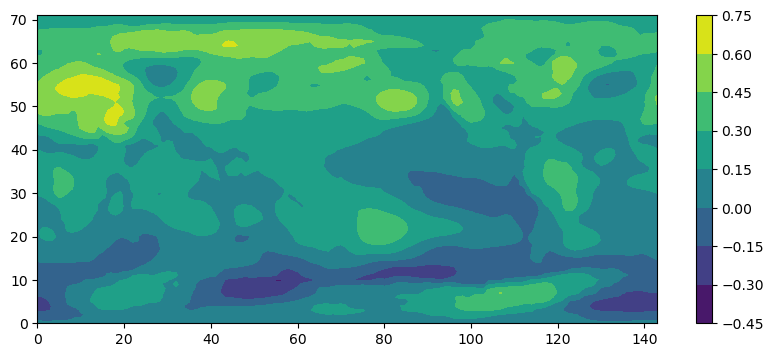

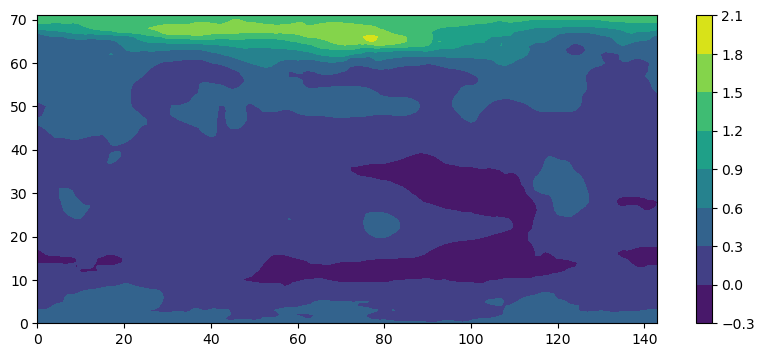

In [5]:
for i in range(4):
    plt.figure(figsize=(10, 4))
    plt.contourf(np.nanmean(obs_maps[:, i], axis=0))
    plt.colorbar()
    plt.show()

In [6]:
# Define paths to spliced and historical files
spliced_path = '/glade/work/skygale/training-data/seasonal/spliced/'
hist_path = '/glade/work/skygale/training-data/seasonal/hist/'
spliced = glob.glob(spliced_path+region.lower()+'/*')
hist = glob.glob(hist_path+region.lower()+'/*')

# Remove unwanted files
spliced = [model for model in spliced if 'OthersAllEM.nc' not in model]
hist = [model for model in hist if 'OthersAllEM.nc' not in model]

# Store data
splice_X, splice_Y, model_names_spliced_old = get_data(spliced)
hist_X, hist_Y, model_names_hist = get_data(hist)

# Reorganize models by warming indices
models_reorganized = ['E3SM-2-0', 'CanESM5', 'MIROC6', 'MPI-ESM1-2-LR', 'IPSL-CM6A-LR', 'ACCESS-ESM1-5', 'CESM2', 'CESM2_SMBB']
ranked_warming_indices = [model_names_spliced_old.index(name) for name in models_reorganized]
splice_X_array = [splice_X[i] for i in ranked_warming_indices]
splice_Y_array = [splice_Y[i] for i in ranked_warming_indices]
model_names_spliced = [model_names_spliced_old[i] for i in ranked_warming_indices]

# Convert observations into PyTorch tensors
splice_X = []
[splice_X.append(tf.convert_to_tensor(splice_X_array[i])) for i in range(len(splice_X_array))]
splice_Y = []
[splice_Y.append(tf.convert_to_tensor(splice_Y_array[i])) for i in range(len(splice_Y_array))]
obs_maps = tf.convert_to_tensor(obs_maps)

print('Observations | Seasonal Means:', np.round(np.nanmean(actual_trends_obs_means, axis=0), 3))
print('CMIP6 Models | Type:', type(splice_X[0]))

2025-04-07 16:43:41.275366: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-04-07 16:43:41.276661: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2025-04-07 16:43:41.358042: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.73GiB deviceMemoryBandwidth: 836.37GiB/s
2025-04-07 16:43:41.358081: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2025-04-07 16:43:41.360350: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2025-04-07 16:43:41.360412: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

Observations | Seasonal Means: [0.176 0.188 0.179 0.214]
CMIP6 Models | Type: <class 'tensorflow.python.framework.ops.EagerTensor'>


perations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-07 16:43:41.372238: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-04-07 16:43:41.372539: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.73GiB deviceMemoryBandwidth: 836.37GiB/s
2025-04-07 16:43:41.372558: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2025-04-07 16:43:41.372579: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2025-04-07 16:43:41.372589: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2025-04-07 16:43:41.372599: I tensorflow/stream_executor/platform/default/d

In [7]:
for i, splice in enumerate(splice_X):
    print(i+1, np.shape(splice), model_names_spliced[i])
print('\n')
for i, splice in enumerate(splice_Y):
    print(i+1, np.shape(splice), model_names_spliced[i])
print('\n')

# Remove E3SMv2 from training data
if no_E3SM:
    splice_X_cut = splice_X[1:]
    splice_Y_cut = splice_Y[1:]
    model_names_spliced_cut = model_names_spliced[1:]

    for i, splice in enumerate(splice_X_cut):
        print(i+1, np.shape(splice), model_names_spliced_cut[i])
    print('\n')
    for i, splice in enumerate(splice_Y_cut):
        print(i+1, np.shape(splice), model_names_spliced_cut[i])
    print('\nE3SM not included in training data.')
else:
    print('\nE3SM included in training data.')

1 (21, 22, 4, 72, 144) E3SM-2-0
2 (25, 22, 4, 72, 144) CanESM5
3 (50, 22, 4, 72, 144) MIROC6
4 (10, 22, 4, 72, 144) MPI-ESM1-2-LR
5 (11, 22, 4, 72, 144) IPSL-CM6A-LR
6 (25, 22, 4, 72, 144) ACCESS-ESM1-5
7 (50, 22, 4, 72, 144) CESM2
8 (50, 22, 4, 72, 144) CESM2_SMBB


1 (21, 22, 4, 3) E3SM-2-0
2 (25, 22, 4, 3) CanESM5
3 (50, 22, 4, 3) MIROC6
4 (10, 22, 4, 3) MPI-ESM1-2-LR
5 (11, 22, 4, 3) IPSL-CM6A-LR
6 (25, 22, 4, 3) ACCESS-ESM1-5
7 (50, 22, 4, 3) CESM2
8 (50, 22, 4, 3) CESM2_SMBB


1 (25, 22, 4, 72, 144) CanESM5
2 (50, 22, 4, 72, 144) MIROC6
3 (10, 22, 4, 72, 144) MPI-ESM1-2-LR
4 (11, 22, 4, 72, 144) IPSL-CM6A-LR
5 (25, 22, 4, 72, 144) ACCESS-ESM1-5
6 (50, 22, 4, 72, 144) CESM2
7 (50, 22, 4, 72, 144) CESM2_SMBB


1 (25, 22, 4, 3) CanESM5
2 (50, 22, 4, 3) MIROC6
3 (10, 22, 4, 3) MPI-ESM1-2-LR
4 (11, 22, 4, 3) IPSL-CM6A-LR
5 (25, 22, 4, 3) ACCESS-ESM1-5
6 (50, 22, 4, 3) CESM2
7 (50, 22, 4, 3) CESM2_SMBB

E3SM not included in training data.


In [8]:
names = [
        'E3SM-2-0',
        'CanESM5',
        'MIROC6',
        'MPI-ESM1-2-LR',
        'IPSL-CM6A-LR',
        'ACCESS-ESM1-5',
        'CESM2',
        'CESM2_SMBB'
    ]

In [9]:
def get_test_data(paths):
    X_MAPS = []
    Y_DATA = []
    model_names = []
    for path in paths:
        model_names.append(path.split('/')[8][:-3])

        # Load data
        ds = xr.open_dataset(path)
        ds_sel = ds

        # Get SAT & SLP or SLP data
        if SAT_SLP:
            X_maps_sat = ds_sel.X_SAT_SLP[:, :, :, :, :, 0]
            X_maps_slp = ds_sel.X_SAT_SLP[:, :, :, :, :, 1]
            X_maps = [X_maps_sat, X_maps_slp]
            X_maps = np.moveaxis(X_maps, 0, -1)
        else:
            X_maps = np.array(ds_sel.X_SAT_SLP[:, :, :, :, :, 0])

        Y_data = np.array(ds_sel.Y_I_E_SUM)

        # Append to all paths
        X_MAPS.append(X_maps)
        Y_DATA.append(Y_data)

        ds.close()
    return X_MAPS, Y_DATA, model_names


# Store data
splice_test_X, splice_test_Y, splice_test_names = get_test_data(spliced)
# hist_test_X, hist_test_Y, hist_test_names = get_test_data(hist)

# Get indices
'''
hist_model_idx = [
    0, 0,
    2,
    3, 3, 3, 3
]
hist_idx = [
    [1, 16, 1],
    [8, 19, 1],
    [5, 15, 1],
    [1, 22, 1],
    [3, 5, 1],
    [6, 19, 1],
    [9, 0, 1],
]
'''

spliced_model_idx = [
    0,
    1, 1, 1, 1, 1, 1, 1,
    2, 2, 2, 2, 2,
    3,
    5,
    6, 6,
    7,
]
spliced_idx = [
    [3, 30, 1],
    [4, 25, 1],
    [4, 28, 1],
    [20, 28, 1],
    [33, 25, 1],
    [41, 23, 1],
    [42, 27, 1],
    [48, 27, 1],
    [11, 24, 1],
    [25, 25, 1],
    [25, 27, 1],
    [25, 28, 1],
    [36, 28, 1],
    [2, 28, 1],
    [3, 24, 1],
    [2, 28, 1],
    [11, 26, 1],
    [22, 27, 1],
]

'''
keep_hist_X, keep_hist_Y = [], []
for i in range(len(hist_model_idx)):
    model_idx = hist_model_idx[i]
    member, period, season = hist_idx[i][0], hist_idx[i][1], hist_idx[i][2]
    keep_hist_X.append(hist_test_X[model_idx][member, period, season])
    keep_hist_Y.append(hist_test_Y[model_idx][member, period, season, :2])
'''

keep_spliced_X, keep_spliced_Y = [], []
for i in range(len(spliced_model_idx)):
    model_idx = spliced_model_idx[i]
    member, period, season = spliced_idx[i][0], spliced_idx[i][1], spliced_idx[i][2]
    keep_spliced_X.append(splice_test_X[model_idx][member, period, season])
    keep_spliced_Y.append(splice_test_Y[model_idx][member, period, season, :2])

'''
X_test_ = np.concatenate([keep_hist_X, keep_spliced_X], axis=0)
Y_test_ = np.concatenate([keep_hist_Y, keep_spliced_Y], axis=0)
'''

X_test_ = tf.convert_to_tensor(keep_spliced_X)
Y_test_ = tf.convert_to_tensor(keep_spliced_Y)

X_test_.shape, Y_test_.shape, type(X_test_), type(Y_test_)

(TensorShape([18, 72, 144]),
 TensorShape([18, 2]),
 tensorflow.python.framework.ops.EagerTensor,
 tensorflow.python.framework.ops.EagerTensor)

In [10]:
# Create arrays for which to store result
cv_preds_and_vals = []
cv_obs = []
cv_mse = []
prediction_error = []

# Main training loop
Xscale = MinMaxScaler()
Yscale = MinMaxScaler()

with tf.device('/GPU:0'):

    # Loop through each large ensemble we test on
    for cv in range(len(splice_X)):
        # print('Cross Validation:', model_names_spliced[cv])
        print('Cross Validation #', cv)

        cv_preds_and_vals_one_randomization = []
        cv_obs_one_randomization = []

        # Create the CNN 50 times to cut noise from random initializations
        for randomization in range(50):
            # Define training data
            X_train, Y_train = prepare_data(splice_X_cut, splice_Y_cut, hist_X, hist_Y, cv)

            # Reshape training data for CNN
            X_train_reshaped = tf.reshape(X_train, (tf.shape(X_train)[0], -1))
            Y_train_reshaped = Y_train[:, :2]

            # Define testing data
            X_test = X_test_  # splice_X[cv][:, -6, s]
            X_test_reshaped = tf.reshape(X_test, (tf.shape(X_test)[0], -1))
            Y_test_reshaped = Y_test_  # splice_Y[cv][:, -6, s, :2]

            # Scale training and testing data
            Xscale.fit(X_train_reshaped.numpy())
            Yscale.fit(Y_train_reshaped.numpy())
            X_train_scaled = Xscale.transform(X_train_reshaped.numpy())
            X_test_scaled = Xscale.transform(X_test_reshaped.numpy())
            Y_train_scaled = Yscale.transform(Y_train_reshaped.numpy())

            # Put data back into sample x map x channel shape
            if SAT_SLP:
                X_train_scaled = tf.reshape(X_train_scaled, tf.shape(X_train))
                X_test_scaled = tf.reshape(X_test_scaled, tf.shape(X_test))
            else:
                X_train_scaled = tf.reshape(X_train_scaled, (tf.shape(X_train)[0], tf.shape(X_train)[1], tf.shape(X_train)[2], 1))
                X_test_scaled = tf.reshape(X_test_scaled, (tf.shape(X_test)[0], tf.shape(X_test)[1], tf.shape(X_test)[2], 1))

            # Create the model
            model = create_CNN(input_shape=X_train_scaled.shape[1:])

            # Fit the model with validation data
            model.fit(X_train_scaled, Y_train_scaled,
                      epochs=10,
                      verbose=0,
                      batch_size=32,
                      shuffle=True)

            # Make predictions on testing data
            Y_pred_scaled = model.predict(X_test_scaled)
            Y_preds_unscaled = Yscale.inverse_transform(Y_pred_scaled)

            # Reshape prediction and actual values
            Y_pred = tf.transpose(Y_preds_unscaled).numpy().tolist()
            Y_test_one_model = tf.transpose(Y_test_reshaped).numpy().tolist()

            # Append sum values to prediction and actual values
            Y_pred.append(np.nansum(Y_pred, axis=0))
            Y_test_one_model.append(np.nansum(Y_test_one_model, axis=0))
            cv_preds_and_vals_one_randomization.append([tf.transpose(Y_pred), tf.transpose(Y_test_one_model)])

            # Prepare predicting data
            obs_map = obs_maps[:, s]
            X_obs_reshaped = tf.reshape(obs_map, (tf.shape(obs_map)[0], -1))

            # Make predictions on observations
            X_obs_scaled = Xscale.transform(X_obs_reshaped.numpy())
            X_obs_map_scaled = tf.reshape(X_obs_scaled, tf.shape(obs_map))
            obs_Y_pred_scaled = model.predict(X_obs_map_scaled)

            # Reshape observation prediction values
            obs_Y_pred_unscaled = Yscale.inverse_transform(obs_Y_pred_scaled)
            Y_obs = tf.transpose(obs_Y_pred_unscaled).numpy().tolist()
            Y_obs.append(np.nansum(Y_obs, axis=0))
            cv_obs_one_randomization.append(Y_obs)

        # Find mean prediction for the current cross-validation fold
        mean_of_randomizations_val = tf.reduce_mean(cv_preds_and_vals_one_randomization, axis=0).numpy()
        mean_of_randomizations_obs = tf.reduce_mean(cv_obs_one_randomization, axis=0).numpy()
        error = mean_of_randomizations_val[0] - mean_of_randomizations_val[1]
        prediction_error.append(error)
        mse_of_cv = [tf.reduce_mean(tf.square(error[:, i])).numpy() for i in range(3)]

        # Append to arrays of all cvs
        cv_preds_and_vals.append(mean_of_randomizations_val)
        cv_obs.append(mean_of_randomizations_obs)
        cv_mse.append(mse_of_cv)

new_errors = []
for error in prediction_error:
    squared_error = np.multiply(error, error)
    new_errors.append(squared_error/len(squared_error))
new_errors_all = np.concatenate(new_errors)
new_errors_sum = np.nansum(new_errors_all, 0)
new_errors_std = np.sqrt(new_errors_sum/8)
# print(new_errors_std)

# Save values
for i in range(len(names)):
    np.save('./preds_and_vals/18_members/'+region.lower()+'_'+str(names[i])+'.npy', np.array(cv_preds_and_vals[i]))
np.save('./preds_and_vals/18_members/'+region+'_obs.npy', np.array(cv_obs))

print('Done!')

Cross Validation # 0


2025-04-07 16:43:57.571613: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2025-04-07 16:43:57.592158: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz
2025-04-07 16:43:57.828156: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2025-04-07 16:43:58.100060: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


Cross Validation # 1
Cross Validation # 2
Cross Validation # 3
Cross Validation # 4
Cross Validation # 5
Cross Validation # 6
Cross Validation # 7
Done!


Sigma_obs: 0.0022220295
Sigma_CNN: 0.018270966
Sigma_obs: 0.0053284825
Sigma_CNN: 0.017962703
Sigma_obs: 0.0056213047
Sigma_CNN: 0.003561403


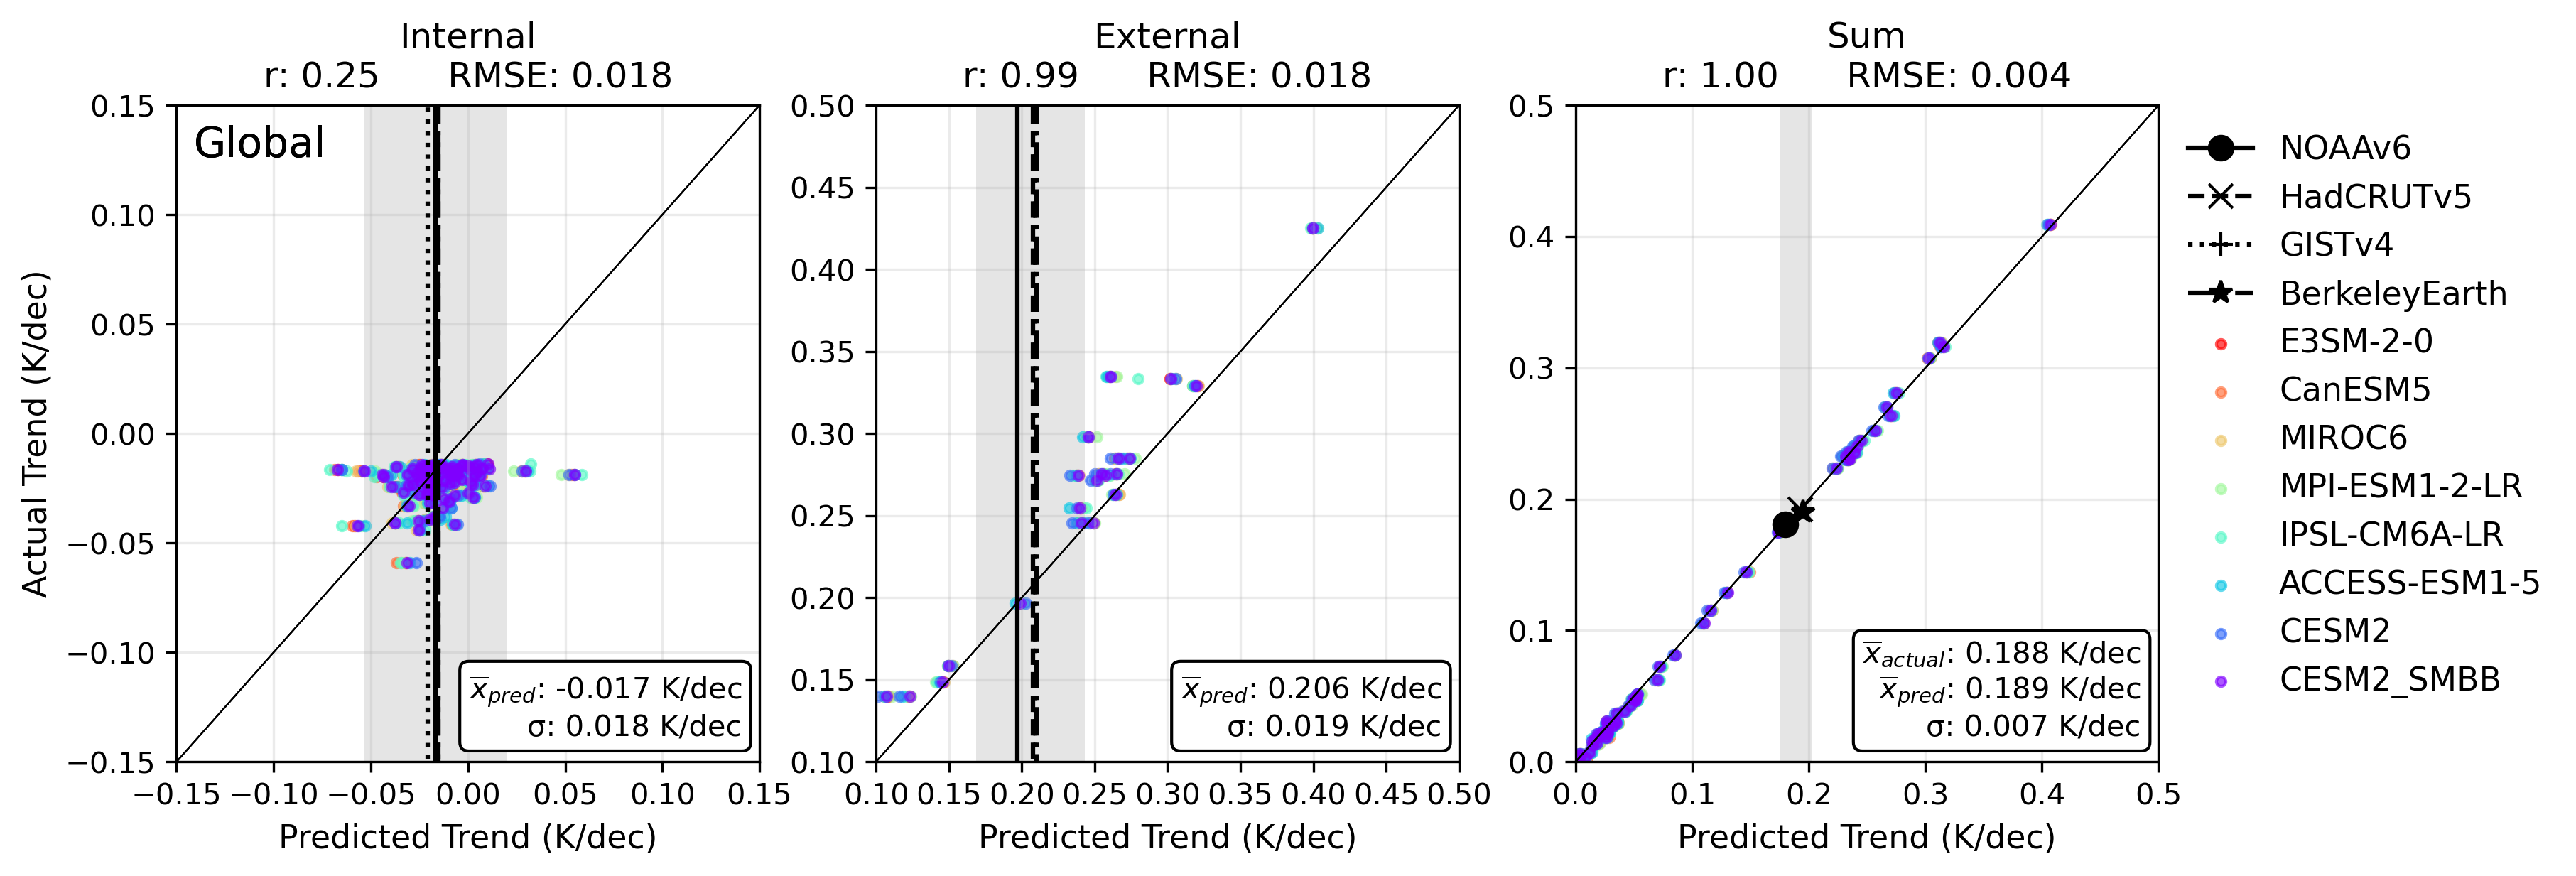

In [13]:
# Make final prediction figure
titles = ['Internal', 'External', 'Sum']
obs_labels = ['NOAAv6', 'HadCRUTv5', 'GISTv4', 'BerkeleyEarth']
obs_markers = ['o', 'x', '+', '*']
linestyles = ['-', '--', ':', '-.']
colors = cm.rainbow(np.linspace(0, 1, 8))[::-1]
bbox = dict(facecolor='white', ec='black', boxstyle='round')

if region == 'Arctic':
    ticks = np.arange(-0.75, 0.751, 0.25),  np.arange(0, 1.251, 0.25), np.arange(0, 2.1, 0.5)
    top = 0.1
else:
    ticks = np.arange(-0.15, 0.151, 0.05),  np.arange(0.1, 0.51, 0.05), np.arange(0, 0.51, 0.1)
    top = 0.02

obs_actual = str(np.round(np.nanmean(actual_trends_obs_means, axis=0), 3)[s])

fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=300, facecolor='white')
cv_preds_and_vals_ = cv_preds_and_vals
cv_obs_ = np.swapaxes(np.array(cv_obs), 0, 2)

for i in range(3):
    axs[0].text(0.03, 0.97, f'{region}', fontsize=14, transform=axs[0].transAxes, va='top', ha='left')
    all_obs_spread = np.nanmean(cv_obs_[:, i, :], 1).ravel()
    obs_mean = np.nanmean(all_obs_spread)
    sigma_obs = np.nanstd(all_obs_spread)
    sigma_cnn = new_errors_std[i]
    print('Sigma_obs:', sigma_obs)
    print('Sigma_CNN:', sigma_cnn)
    sigma = np.sqrt(sigma_obs**2+sigma_cnn**2)
    axs[i].axvspan(obs_mean-2*sigma, obs_mean+2*sigma, color='grey', alpha=0.2, ec=None)
    cv_obs_set = cv_obs_[:, i, :].reshape(4, 3, 8) if SAT_SLP else cv_obs_[:, i, :].reshape(4, 8)
    mean = str(round(obs_mean, 3))
    std = str(round(sigma, 3))

    if i in [0, 1]:
        text = '$\overline{x}$$_{pred}$: '+mean+' K/dec\nσ: '+std+' K/dec'
        axs[i].text(0.97, 0.03, text, transform=axs[i].transAxes, fontsize=10, va='bottom', ha='right', bbox=bbox)
        for idx in range(len(cv_obs_set)):
            obs_set_all_cv = cv_obs_set[idx]
            mean_obs = np.nanmean(obs_set_all_cv)
            axs[i].plot(np.repeat(mean_obs, 3), [-5, 0.3, 5], linestyle=linestyles[idx], linewidth=1.5, color='k', label=obs_labels[idx])
    else:
        text = '$\overline{x}$$_{actual}$: '+obs_actual+' K/dec'+'\n$\overline{x}$$_{pred}$: '+mean+' K/dec\nσ: '+std+' K/dec'
        axs[i].text(0.97, 0.03, text, transform=axs[i].transAxes, fontsize=10,  va='bottom', ha='right', bbox=bbox)
        for idx in range(len(cv_obs_set)):
            obs_set_all_cv = cv_obs_set[idx]
            mean_obs = np.nanmean(obs_set_all_cv)
            axs[i].plot(mean_obs, actual_trends_obs_means[:, s][idx], linestyle=linestyles[idx], marker=obs_markers[idx], markersize=8, color='k', label=obs_labels[idx])

for model_idx, set_of_preds_and_vals in enumerate(cv_preds_and_vals_):
    Y_pred = np.array(set_of_preds_and_vals[0])
    Y_test = np.array(set_of_preds_and_vals[1])
    for i in range(3):
        axs[i].scatter(Y_pred[:, i], Y_test[:, i], color=colors[model_idx], s=10, alpha=0.65, label=model_names_spliced[model_idx])
        axs[i].axline((0, 0), slope=1, color='k', alpha=0.5, linewidth=0.5)
        axs[i].set_xticks(ticks[i])
        axs[i].set_yticks(ticks[i])
        axs[i].set_ylim(ticks[i][0], ticks[i][-1])
        axs[i].set_xlim(ticks[i][0], ticks[i][-1])

all_preds_and_vals = np.concatenate(cv_preds_and_vals_, axis=1)

for i in range(3):
    Y_pred = all_preds_and_vals[0]
    Y_test = all_preds_and_vals[1]
    MSE = np.nanmean(np.square(Y_pred[:, i]-Y_test[:, i]), 0)
    MSE_str = str(np.around(MSE, 5))
    r = stats.pearsonr(Y_pred[:, i], Y_test[:, i])[0]
    r_str = str(np.around(r, 3))
    axs[i].set_title(titles[i]+'\nr: {:.2f}'.format(round(r, 2))+'      RMSE: {:.3f}'.format(round(np.sqrt(MSE), 3)), fontsize=12)
    axs[i].set_xlabel('Predicted Trend (K/dec)', fontsize=11)
    axs[0].set_ylabel('Actual Trend (K/dec)', fontsize=11)
    axs[i].grid(alpha=0.25)
    axs[i].tick_params(axis='both', which='major', labelsize=10)
    axs[i].tick_params(axis='both', which='minor', labelsize=10)

axs[2].legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False, fontsize=11)
plt.show()